# Isolationg the Stellar Rotation Period

To measure the rotation period of the star, we'll make a periodogram of the long cadence fluxes and see what periods stick out. 

#### Outline

* Mask out transits from long cadence light curve

* Use [`gatspy.periodic.LombScargle`](http://www.astroml.org/gatspy/periodic/API.html#gatspy.periodic.LombScargle) to make a periodogram for the flux and to fit for the dominant period

* Visualize!

### Loading, masking:

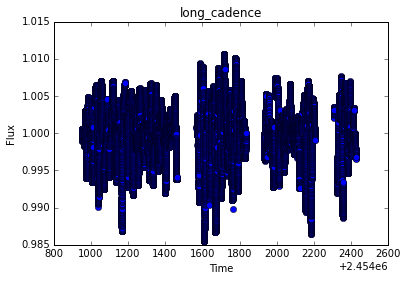

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
from gatspy import periodic
import numpy as np
import warnings

import datacleaner
reload(datacleaner)
from datacleaner import LightCurve

# Load normalized long cadence light curve, mask out the transits 
long_cadence = LightCurve(name='long_cadence', 
                          **LightCurve.from_dir('normalized_long').mask_in_transit())
long_cadence.plot()

### Get the periodogram, best period

In [72]:
#model = periodic.LombScargleFast(fit_period=True)
model = periodic.LombScargle(fit_period=True, Nterms=4)
model.optimizer.period_range = (20, 40)
model.fit(long_cadence.times.jd, long_cadence.fluxes, long_cadence.errors);

periods = np.linspace(model.optimizer.period_range[0],
                      model.optimizer.period_range[1], 
                      10000)
print("Best period: {0}".format(model.best_period))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

Finding optimal frequency:
 - Estimated peak width = 0.00427
 - Using 5 steps per peak; omega_step = 0.000855
 - User-specified period range:  20 to 40
 - Computing periods at 185 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Best period: 29.9778928355


### Visualize

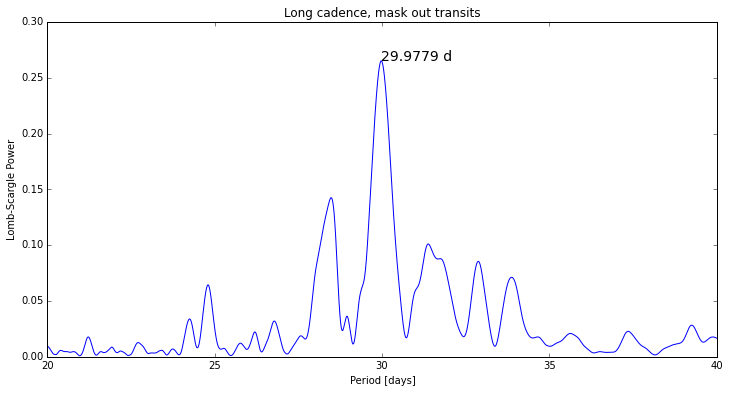

In [83]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(periods, scores)
ax.set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
max_ind = np.argmax(scores)
ax.text(periods[max_ind], scores[max_ind], 
        "{0:.4f} d".format(model.best_period),
        fontsize=14)
plt.show()

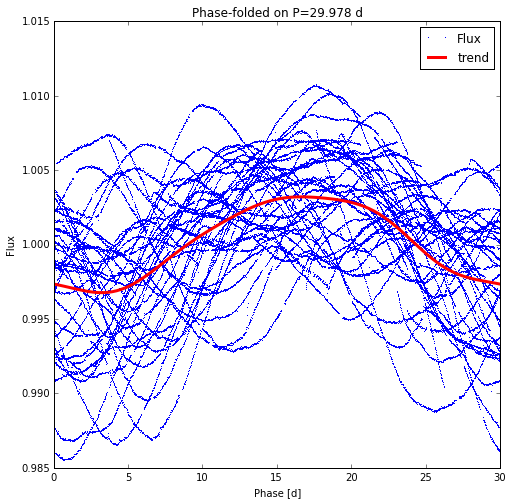

In [86]:
phase = long_cadence.times.jd % model.best_period
tfit = np.linspace(0, model.best_period, 100)
yfit = model.predict(tfit, period=model.best_period)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phase, long_cadence.fluxes, ',', label='Flux')
ax.plot(tfit, yfit, 'r', lw=3, label='trend')
ax.set(xlabel='Phase [d]', ylabel='Flux', title='Phase-folded on P={0:.3f} d'.format(model.best_period))
ax.legend()
plt.show()